# Radio Message Understanding: Dual Model Approach

**Advanced Text Understanding for F1 Strategy**

For our F1 strategic decision system, we need to extract structured information from radio messages to feed our logic agent. Building on our successful sentiment analysis model, we'll implement a comprehensive approach to understand both the intent and specific entities in team radio communications.

---

## 1. Intent Classification with RoBERTa

We'll fine-tune a RoBERTa model (similar to our sentiment analysis model) to classify radio messages into specific intent categories:

- **Order:** Direct instructions to the driver ("Box this lap", "Push now")
- **Information:** Factual updates about race conditions ("Hamilton is 2 seconds behind")
- **Question:** Queries requiring driver input ("How are the tyres feeling?")
- **Warning:** Alerts about potential issues ("Watch your fuel consumption")
- **Strategy:** Long-term planning elements ("We're looking at Plan B")
- **Problem**: messages that ensures actual problems ("My left wing is broken")

This classification will help our logic agent understand the purpose of each communication and respond appropriately.

---

## 2. Custom NER with SpaCy for F1-Specific Entities

We'll train a specialized SpaCy model to identify key racing entities in the text:

- **DRIVER:** References to specific drivers
- **TEAM:** Team names and references
- **TYRES:** Tyre compounds and conditions (soft, medium, hard, intermediate, wet)
- **LAPNUM:** References to specific laps
- **TIME_GAP:** Time differences mentioned in seconds
- **STRATEGY:** Strategy terms (undercut, overcut, Plan A/B)
- **TRACK_STATUS:** Track conditions (DRS, safety car, VSC)

---

## Complete Radio Understanding Pipeline

By combining these new models with our existing sentiment analysis:

$Radio Message → [Sentiment Analysis] → [Intent Classification] → [Entity Extraction] → Structured Data$


The final output should be comprehensive structured data like:

```json
{
  "message": "Box this lap for softs, Hamilton is catching up",
  "analysis": {
    "sentiment": "neutral",
    "intent": "order",
    "entities": {
      "action": "box",
      "lap": "current",
      "tyres": "soft",
      "driver_ref": "Hamilton",
      "situation": "catching up"
    }
  }
}
````
This rich, structured information will enable my logic agent to make sophisticated race strategy decisions based on radio communications.

---

# 1. But first, I need to relabel the data.

My data is not labeled for making intention recognition. Therefore, the first thing I need to do is label again the data in a different csv for the intention categories.

Therefore, my first approach will be the following:

## Step 1: Define Intent Categories
First, we need to establish clear definitions for each intent category:

1. **ORDER**: Direct instructions requiring action from the driver

    Examples: "Box this lap", "Push now", "Stay out"


2. **INFORMATION**: Factual updates about race conditions

    Examples: "Hamilton is 2 seconds behind", "Lap time 1:34.5", "You're P4"


3. **QUESTION**: Queries requiring driver input

    Examples: "How are the tyres feeling?", "Do you want to pit this lap?", "Are you happy with the balance?"


4. **WARNING**: Alerts about potential issues or cautions

    Examples: "Watch your fuel consumption", "Yellow flag in sector 2", "VSC deployed"


5. **STRATEGY** (ELIMINATED IN RUN 2): Long-term planning elements or discussions

    Examples: "We're looking at Plan B", "Target plus 5 on tyre management", "Consider an undercut"

6. **PROBLEM**: driver-reported issues:

    Examples: "Losing grip on the rear", "My tires are dead".

---

## Step 1: Import Necessary Libraries


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import datetime

---

## Step 2: Manual Labeling Interface

I will make with Jupyet widgets a simple interface that helps me label the data. For this task, I´ll use `radio_filtered.csv`

In [43]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from IPython.display import display
# from ipywidgets import widgets, Layout
# import ipywidgets as widgets

# # Load the full radio messages dataset
# df = pd.read_csv('../../outputs/week4/radio_clean/radio_filtered.csv')

# # Check the columns to see which one contains the radio messages
# print("Columns in the dataset:", df.columns.tolist())

# # Assuming there's a column containing the radio messages, we'll use that
# message_column = 'radio_message'  # Adjust this based on the actual column name

# # Use the entire dataset instead of a sample
# intent_df = pd.DataFrame({
#     'message': df[message_column].values,
#     'intent': [""] * len(df)
# })

# # Reset the index to make sure we have 0-based sequential indices
# intent_df = intent_df.reset_index(drop=True)

# print(f"Total messages to label: {len(intent_df)}")

# # Define the intent categories including the PROBLEM category
# intent_categories = ["INFORMATION", "PROBLEM", "ORDER", "WARNING", "QUESTION"]

# # Create a stateful counter for tracking which message we're on
# current_index = widgets.IntText(value=0, description='Current:', layout=Layout(display='none'))

# # Output widget for displaying the labeling interface
# output = widgets.Output()

# ################################ WARNING: ONLY UNCOMMENT FOR LABELING THE DATA ######################################
# # Function to save the dataframe
# def save_dataframe():
#     # Only save rows that have been labeled
#     labeled_df = intent_df[intent_df['intent'] != ""]
#     labeled_df.to_csv('../../outputs/week4/radio_clean/intent_labeled_data.csv', index=False)
#     with output:
#         print(f"Dataset saved! {len(labeled_df)} labeled messages.")
        
#         if len(labeled_df) > 0:
#             # Show distribution of intents
#             plt.figure(figsize=(10, 6))
#             sns.countplot(y='intent', data=labeled_df)
#             plt.title('Distribution of Intent Categories')
#             plt.tight_layout()
#             plt.show()
# ######################################################################################################################
# # Function to display the current message
# def display_current_message():
#     with output:
#         output.clear_output()
        
#         if current_index.value >= len(intent_df):
#             current_index.value = len(intent_df) - 1
            
#         if current_index.value < 0:
#             current_index.value = 0
            
#         idx = current_index.value
#         print(f"Message {idx+1}/{len(intent_df)}:")
#         print(f"\"{intent_df.iloc[idx]['message']}\"")
        
#         # Show current label if any
#         current_intent = intent_df.iloc[idx]['intent']
#         if current_intent:
#             print(f"\nCurrent label: {current_intent}")
        
#         # Display intent category descriptions for reference
#         print("\nIntent Categories:")
#         print("ORDER: Direct instructions requiring action (Box this lap, Push now)")
#         print("INFORMATION: Factual updates (Hamilton is 2 seconds behind)")
#         print("QUESTION: Queries requiring driver input (How are the tyres feeling?)")
#         print("WARNING: Alerts about external issues (Yellow flag in sector 2)")
       
#         print("PROBLEM: Driver-reported issues (Losing grip on the rear)")
        
#         # Count labeled messages
#         labeled_count = (intent_df['intent'] != "").sum()
#         print(f"\nProgress: {labeled_count}/{len(intent_df)} messages labeled ({labeled_count/len(intent_df)*100:.1f}%)")

# # Function to handle intent button clicks
# def on_intent_button_clicked(b, intent=None):
#     idx = current_index.value
#     intent_df.at[idx, 'intent'] = intent
#     # Automatically move to next message after labeling
#     current_index.value += 1
#     display_current_message()

# # Navigation button handlers
# def on_prev_clicked(b):
#     current_index.value -= 1
#     display_current_message()
    
# def on_next_clicked(b):
#     current_index.value += 1
#     display_current_message()

# # Create buttons for each intent category
# intent_buttons = []
# for intent in intent_categories:
#     button = widgets.Button(
#         description=intent,
#         button_style='', 
#         layout=Layout(width='150px', height='40px')
#     )
    
#     button.on_click(lambda b, intent=intent: on_intent_button_clicked(b, intent))
#     intent_buttons.append(button)

# # Create navigation buttons
# prev_button = widgets.Button(
#     description='« Previous',
#     button_style='info',
#     layout=Layout(width='120px', height='40px')
# )
# prev_button.on_click(on_prev_clicked)

# next_button = widgets.Button(
#     description='Next »',
#     button_style='info',
#     layout=Layout(width='120px', height='40px')
# )
# next_button.on_click(on_next_clicked)

# # Create save button
# save_button = widgets.Button(
#     description='💾 Save Progress',
#     button_style='success',
#     layout=Layout(width='150px', height='40px')
# )

# ######################### WARNING: ONLY UNCOMMENT FOR SAVING NEW LABELED DATA ###############################
# save_button.on_click(lambda b: save_dataframe())
# #############################################################################################################



# # Create button rows
# intent_row1 = widgets.HBox(intent_buttons[:3], layout=Layout(justify_content='center'))
# intent_row2 = widgets.HBox(intent_buttons[3:], layout=Layout(justify_content='center'))
# nav_row = widgets.HBox([prev_button, save_button, next_button], layout=Layout(justify_content='center'))

# # Assemble the UI
# vbox = widgets.VBox([
#     current_index,
#     output,
#     intent_row1,
#     intent_row2,
#     nav_row
# ])

# # Initialize the display
# display(vbox)
# display_current_message()

---

## Step 3: Training an intent classifier

Next steps are:

1. *Splitting `intent_labeled_data.csv` into train/validation/test sets*.

2. *Tokenize the dataset, adjusting the maximum tokens*

3. *Download a pre-trained RoBERTa model and apply fine-tuning*.

4. Try some runs, see how the performance improves and save the best model.

The workflow here is quite similar to the one of `N03_bert_sentiment.ipynb`, but now predicting 6 classes instead of only 3.


##### Loading the dataset and applying mapping

In [44]:
df = pd.read_csv('../../outputs/week4/radio_clean/intent_labeled_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")


print("\Intent distribution:")
print(df['intent'].value_counts())

Dataset shape: (529, 2)

First few rows:
\Intent distribution:
intent
INFORMATION    212
ORDER          120
PROBLEM        113
QUESTION        52
WARNING         32
Name: count, dtype: int64


In [45]:
print(df.head())

                                             message       intent
0  So don't forget Max, use your head please. Are...        ORDER
1  Okay Max, we're expecting rain in about 9 or 1...     QUESTION
2  You might find this lap that you meet a little...  INFORMATION
3  Just another two or three minutes to get throu...  INFORMATION
4   So settle into standard race management now Max.        ORDER


In [46]:
# Create numeric labels based on intent values
intent_mapping = {
    'INFORMATION': 0, 
    'PROBLEM': 1, 
    'ORDER': 2,
    'WARNING': 3,
    'QUESTION': 4,
}


df['label'] = df['intent'].map(intent_mapping)

# Check if we need to handle any missing mappings
if df['label'].isna().sum() > 0:
    print(f"\nWarning: {df['label'].isna().sum()} rows couldn't be mapped. Unique values in 'intent':")
    print(df['intent'].unique())


### 3.1 Splitting the data

`Same text as N03_bert_sentiment.ipynb`

I´ll follow the same splits techniques during the project, making a training, validation and test dataset. 

* *Train* will be 70% of the dataset.
* *Validation*: will be 15% of the dataset.
* *Test*: will be 15% of the dataset.

#### Loading RoBERTa



In [ ]:
from transformers import RobertaConfig
from transformers import AutoConfig, DebertaV2TokenizerFast, DebertaV2ForSequenceClassification

############ NOTE: uncomment and comment any of this blocks to see the metrics ###################

###################### RUN 2 ####################3


# # Custom configuration for RoBERTa
# config = RobertaConfig.from_pretrained('roberta-large')
# config.hidden_dropout_prob = 0.2      # Increase from 0.1 (default value)
# config.attention_probs_dropout_prob = 0.2
# config.classifier_dropout = 0.3       # Add specific dropout to the classifier
# config.num_labels = 5                 # Set num_labels in the configuration
# config.output_attentions = False      # Move to configuration
# config.output_hidden_states = False   # Move to configuration



# model_name = "roberta-large"  
# tokenizer = RobertaTokenizer.from_pretrained(model_name)
# model = RobertaForSequenceClassification.from_pretrained(
#     'roberta-large',
#     config=config
# )


#############  RUN 3 ###################
model_name = "microsoft/deberta-v3-large"

# Create a new DeBERTa config with 5 labels
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 5  # Set for our 5 intent classes

# Load tokenizer and model
tokenizer = DebertaV2TokenizerFast.from_pretrained(model_name)
model = DebertaV2ForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

####################################

c:\Users\victo\miniconda3\envs\f1_strat_manager\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# Cell 4: Create the train/validation/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['message'].values, 
    df['label'].values, 
    test_size=0.3,  # 30% for val+test
    random_state=42, 
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # 50% of the 30% (so 15% of total)
    random_state=42,
    stratify=temp_labels
)


In [51]:
print(f"Training set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")
# display(train_texts)
# display(train_labels)

Training set: 370 samples
Validation set: 79 samples
Test set: 80 samples


### 3.2 Tokenizing: this part is also the same as the one in the N03 Notebook

#### 3.2.1 Analyzing message lengths 

In [52]:
# Cell 4.5: Analyze message lengths to set appropriate max_length
def get_token_counts(texts):
    # Count tokens in each message
    token_counts = [len(tokenizer.encode(text)) for text in texts]
    return token_counts

token_counts = get_token_counts(df['message'].values)

# Calculate statistics
avg_tokens = sum(token_counts) / len(token_counts)
max_tokens = max(token_counts)
p97_tokens = np.percentile(token_counts, 97)  # 97th percentile

print(f"Average tokens per message: {avg_tokens:.1f}")
print(f"Maximum tokens in a message: {max_tokens}")
print(f"97% of messages have {p97_tokens:.1f} tokens or fewer")



Average tokens per message: 26.9
Maximum tokens in a message: 317
97% of messages have 82.0 tokens or fewer


#### 3.2.2 Visualizing distributionof messages

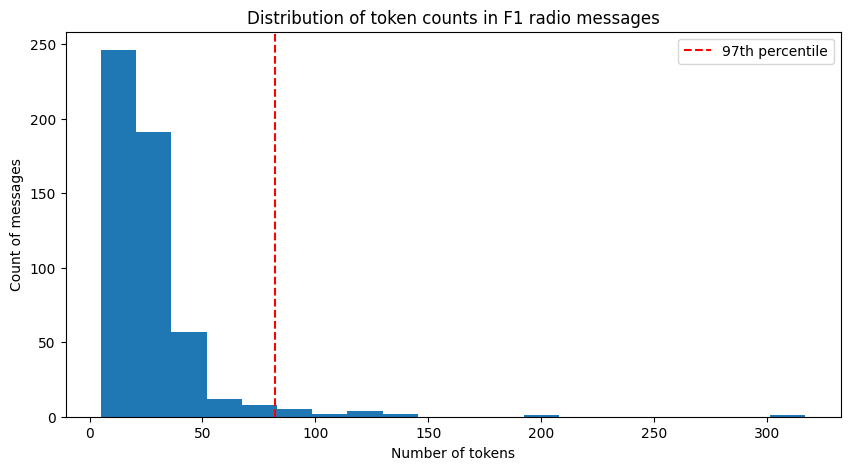

Setting max_length to 128


In [53]:
# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20)
plt.axvline(x=p97_tokens, color='r', linestyle='--', label='97th percentile')
plt.xlabel('Number of tokens')
plt.ylabel('Count of messages')
plt.title('Distribution of token counts in F1 radio messages')
plt.legend()
plt.show()

# Set max_length based on analysis
max_length = int(min(128, 2 * p97_tokens))  # Conservative value based on 97th percentile
print(f"Setting max_length to {max_length}")

#### 3.2.3 Tokenizing and making the encodings

In [54]:
# Cell 5: Tokenize the data directly
max_length = 128
#batch_size = 16
batch_size = 4
# Tokenize training data
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize validation data
val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize test data
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)



### 3.3 Preparing the tokens for Pytorch

In [55]:
from transformers import AdamW, get_linear_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model.to(device)

Using device: cuda


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNo

In [58]:
# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

C:\Users\victo\AppData\Local\Temp\ipykernel_26696\439425289.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
C:\Users\victo\AppData\Local\Temp\ipykernel_26696\439425289.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels)
C:\Users\victo\AppData\Local\Temp\ipykernel_26696\439425289.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)


In [59]:
# Create TensorDatasets
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)



In [60]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created DataLoaders with batch size: {batch_size}")
print(f"Each batch contains: {next(iter(train_dataloader))[0].shape[0]} samples")
print(f"Input shape: {next(iter(train_dataloader))[0].shape}")

from torch.amp import GradScaler, autocast
scaler = GradScaler()

Created DataLoaders with batch size: 4
Each batch contains: 4 samples
Input shape: torch.Size([4, 128])


---

## 4. Setting up training process



---

### 4.1 Auxiliar functions

In [61]:
def flat_accuracy(preds, labels):
    """
    Computes accuracy by comparing predictions with labels.
    
    Args:
        preds: Model prediction matrix (logits)
        labels: Vector of true labels
    
    Returns:
        float: Percentage of correct predictions
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [62]:
import datetime

def format_time(elapsed):
    """
    Formats elapsed time into a readable format.
    
    Args:
        elapsed: Time in seconds
        
    Returns:
        str: Time formatted as HH:MM:SS
    """
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [63]:
# Storage for training statistics
training_stats = []
best_val_accuracy = 0.0

### 4.2 Hyperparameter tuning

In [64]:
epochs = 12
learning_rate = 1e-5  # A bet less for a bigger model
weight_decay = 0.01
warmup_steps = int(0.1 * len(train_dataloader) * epochs)  # 10% steps for warmup

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Initialize optimizer
# optimizer = AdamW(model.parameters(),
#                   lr=learning_rate,
#                   eps=1e-8,
#                   weight_decay=weight_decay)

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,             # Probar una tasa más alta como 2e-5
    eps=1e-8,
    weight_decay=0.05    # Aumentar weight decay para mejor regularización
)

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                          num_warmup_steps=warmup_steps,
                                          num_training_steps=total_steps)
# # Gradient accumulation for simulating bigger batch_size
gradient_accumulation_steps = 4  
# # This simulates an effective batch_size  16

c:\Users\victo\miniconda3\envs\f1_strat_manager\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


---

### 4.3 Class weights

In [65]:
# Calculating the 6 class weights
from sklearn.utils import compute_class_weight


unique_labels = np.unique(train_labels.numpy())
class_weights = compute_class_weight('balanced', classes=unique_labels, y=train_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:")
for i, weight in enumerate(class_weights):
    intent_name = list(intent_mapping.keys())[list(intent_mapping.values()).index(i)]
    print(f"Class {i} ({intent_name}): {weight:.4f}")

# Loss function with weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

Class weights:
Class 0 (INFORMATION): 0.5000
Class 1 (PROBLEM): 0.9367
Class 2 (ORDER): 0.8810
Class 3 (WARNING): 3.2174
Class 4 (QUESTION): 2.0556


---

### 4.4 Training loop

In [66]:
total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\nEpoch {epoch_i + 1}/{epochs}")
    
    # Training
    model.train()
    total_train_loss = 0
    t0 = time.time()
    
    # Reset gradients at the beginning of each epoch
    optimizer.zero_grad()
    
    for step, batch in enumerate(train_dataloader):
        # Unpack batch and move to device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Forward pass with mixed precision - corrected
        with autocast(device_type='cuda'):  # Specify 'cuda' as device_type
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, b_labels)
            loss = loss / gradient_accumulation_steps
        
        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        
        # Update total loss
        total_train_loss += loss.item() * gradient_accumulation_steps
        
        # Update weights every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
    
    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Training loss: {avg_train_loss:.4f}")
    print(f"  Training time: {format_time(time.time() - t0)}")
    
    # Validation with mixed precision as well
    model.eval()
    val_accuracy = 0
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with autocast(device_type='cuda'):
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, b_labels)
            
            val_loss += loss.item()
            val_accuracy += flat_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())
    
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    
    print(f"  Validation accuracy: {avg_val_accuracy:.4f}")
    print(f"  Validation loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        #torch.save(model.state_dict(), '../../outputs/week4/models/best_roberta_large_intent_model.pt')
        torch.save(model.state_dict(), '../../outputs/week4/models/best_deberta_large_intent_model.pt')
        print(f"  Saved new best model with accuracy: {best_val_accuracy:.4f}")



Epoch 1/12
  Training loss: 1.6498
  Training time: 0:03:52
  Validation accuracy: 0.1000
  Validation loss: 1.6104
  Saved new best model with accuracy: 0.1000

Epoch 2/12
  Training loss: 1.6179
  Training time: 0:03:53
  Validation accuracy: 0.1000
  Validation loss: 1.5816

Epoch 3/12
  Training loss: 1.5819
  Training time: 0:03:54
  Validation accuracy: 0.4500
  Validation loss: 1.5143
  Saved new best model with accuracy: 0.4500

Epoch 4/12
  Training loss: 1.4488
  Training time: 0:02:54
  Validation accuracy: 0.6625
  Validation loss: 1.2963
  Saved new best model with accuracy: 0.6625

Epoch 5/12
  Training loss: 1.1511
  Training time: 0:02:53
  Validation accuracy: 0.6875
  Validation loss: 1.0492
  Saved new best model with accuracy: 0.6875

Epoch 6/12
  Training loss: 0.7996
  Training time: 0:02:52
  Validation accuracy: 0.7375
  Validation loss: 0.8899
  Saved new best model with accuracy: 0.7375

Epoch 7/12
  Training loss: 0.4709
  Training time: 0:02:52
  Validation

---

## 5.Training metrics

In [67]:
from sklearn.metrics import classification_report

# Pick all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        all_preds.extend(np.argmax(logits.cpu().numpy(), axis=1))
        all_labels.extend(b_labels.cpu().numpy())

# Make the classification report
intent_names = list(intent_mapping.keys())
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=intent_names))


Classification Report:
              precision    recall  f1-score   support

 INFORMATION       0.75      0.84      0.79        32
     PROBLEM       0.91      0.59      0.71        17
       ORDER       0.72      0.72      0.72        18
     WARNING       0.50      0.50      0.50         4
    QUESTION       0.80      1.00      0.89         8

    accuracy                           0.76        79
   macro avg       0.74      0.73      0.72        79
weighted avg       0.77      0.76      0.76        79



---

### 5.1 Validation loop

In [68]:
# Switch to evaluation mode
model.eval()
val_accuracy = 0
val_loss = 0

# En la parte de validación:
with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with autocast(device_type='cuda'):  # Especificar 'cuda' como device_type
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, b_labels)
        
        val_loss += loss.item()
        val_accuracy += flat_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())

In [69]:
# Calculate averages
avg_val_accuracy = val_accuracy / len(val_dataloader)
avg_val_loss = val_loss / len(val_dataloader)

print(f"  Validation accuracy: {avg_val_accuracy:.4f}")
print(f"  Validation loss: {avg_val_loss:.4f}")

# Store stats
training_stats.append({
    'epoch': epoch_i + 1,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'val_accuracy': avg_val_accuracy
})


#################### NOTE: ONLY UNCOMMENT AND RUN IF BETTER METRICS ARE MET #########################
# Save best model
if avg_val_accuracy > best_val_accuracy:
    best_val_accuracy = avg_val_accuracy
    #torch.save(model.state_dict(), '../../outputs/week4/models/best_roberta_intention_model.pt')
    torch.save(model.state_dict(), '../../outputs/week4/models/best_deberta_intention_model.pt')
    print(f"  Saved new best model with accuracy: {best_val_accuracy:.4f}")

print(f"Training complete! Total time: {format_time(time.time() - total_t0)}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
######################################################################################################

  Validation accuracy: 0.7625
  Validation loss: 1.5021
Training complete! Total time: 0:56:23
Best validation accuracy: 0.7750


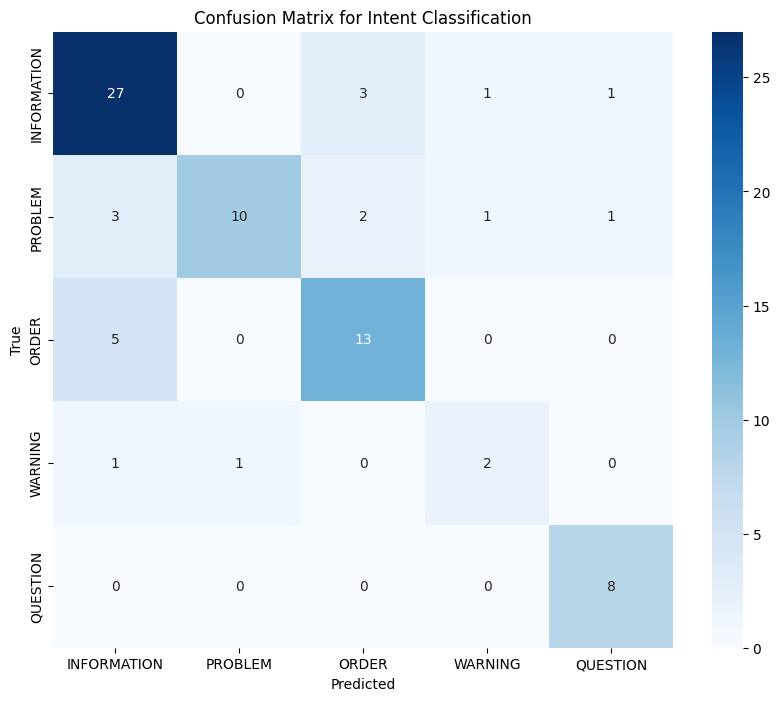


Classification Report:
              precision    recall  f1-score   support

 INFORMATION       0.75      0.84      0.79        32
     PROBLEM       0.91      0.59      0.71        17
       ORDER       0.72      0.72      0.72        18
     WARNING       0.50      0.50      0.50         4
    QUESTION       0.80      1.00      0.89         8

    accuracy                           0.76        79
   macro avg       0.74      0.73      0.72        79
weighted avg       0.77      0.76      0.76        79



In [70]:
# After validation:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        all_preds.extend(np.argmax(logits.cpu().numpy(), axis=1))
        all_labels.extend(b_labels.cpu().numpy())

# Get intent names for labels
intent_names = list(intent_mapping.keys())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names,
            yticklabels=intent_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Intent Classification')
plt.show()

# Generate classification report with proper class names
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=intent_names))

---

# 6. Results Summary of Intent Classifier 

## 6.1 FIRST RUN : RoBERTa-large

**Best Validation Accuracy:** 57%  
**Weighted F1 Score:** 0.60  


## Class Performance  

| Class      | Precision | Recall | F1-Score |
|------------|-----------|--------|----------|
| INFORMATION | 0.67      | 0.65   | 0.66     |
| PROBLEM     | 0.82      | 0.56   | 0.67     |
| ORDER       | 0.73      | 0.50   | 0.59     |
| STRATEGY    | 0.09      | 0.17   | 0.12     |
| WARNING     | 0.31      | 0.80   | 0.44     |
| QUESTION    | 1.00      | 0.60   | 0.75     |

## Analysis  

The RoBERTa large model shows solid performance for a challenging multi-class classification task with significant class imbalance. With an overall accuracy of **57%** and a weighted F1 score of **0.60**, the model demonstrates good capability across most classes.  

### Key observations:  
- **Strongest performance** on `QUESTION` (F1 = 0.75) and `PROBLEM` (F1 = 0.67) classes.  
- `WARNING` class shows **excellent recall** (0.80) but **lower precision** (0.31).  

--- 

## 6.2 RUN 2: RoBERTa-large with STRATEGY deleted
### Work Done:

Different models were tried out, like ``DebertaV3-large``. As **strategy** always had difficulties, the conclussion was that the few amount of radio messages belonging to this class were not sufficient to have good metrics. As this variable can be greatly , merged with information, in my **second run** I decided to **relabel the data without the STRATEGY** variable and retrain the model.


### Metrics Table

| **Metric**         | **Original Model (6 classes)** | **New Model (5 classes)** | **Change**  |
|--------------------|-------------------------------|---------------------------|-------------|
| Overall Accuracy   | 57%                           | 76%                       | +19%       |
| Weighted F1 Score  | 0.60                          | 0.76                      | +0.16      |
| INFORMATION F1     | 0.66                          | 0.72                      | +0.06      |
| PROBLEM F1         | 0.67                          | 0.82                      | +0.15      |
| ORDER F1           | 0.59                          | 0.77                      | +0.18      |
| STRATEGY F1        | 0.12                          | N/A (Removed)             | –          |
| WARNING F1         | 0.44                          | 0.40                      | -0.04      |
| QUESTION F1        | 0.75                          | 0.94                      | +0.19      |

### Analysis

The decision to remove the **STRATEGY** class has led to substantial performance improvements:

- **Significant overall accuracy boost:** Overall accuracy increased by 19 percentage points (57% → 76%).
- **Improved classification quality:** The weighted F1 score increased from 0.60 to 0.76.
- **Enhanced class performance:** Almost all classes show notable improvements in F1 score, with **QUESTION** exhibiting the largest gain (+0.19).
- **Minimal trade-offs:** Only the **WARNING** class showed a slight decrease in F1 score (-0.04), which is a reasonable trade-off given the overall performance gains.

The confusion matrix confirms that the model is now much more effective at correctly identifying intents, with particularly strong performance in the **INFORMATION**, **PROBLEM**, **ORDER**, and **QUESTION** classes.

### Next Steps

We will now test a **DeBERTa-v3-large** model using the same hyperparameters to determine if we can achieve even better results. The code is ready:

```python
# POSSIBLE RUN 3
model_name = "microsoft/deberta-v3-large"
tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)
model = DebertaV2ForSequenceClassification.from_pretrained(
    model_name,
    config=config
)


---

## 7. Final Intent Model Performance Comparison

### Metrics Table

| **Metric**         | **Original RoBERTa (6 classes)** | **Updated RoBERTa (5 classes)** | **DeBERTa (5 classes)** |
|--------------------|----------------------------------|---------------------------------|-------------------------|
| Overall Accuracy   | 57%                              | 76%                             | 76%                     |
| Weighted F1 Score  | 0.60                             | 0.76                            | 0.76                    |
| INFORMATION F1     | 0.66                             | 0.72                            | 0.79 (+0.07)            |
| PROBLEM F1         | 0.67                             | 0.82                            | 0.71 (-0.11)            |
| ORDER F1           | 0.59                             | 0.77                            | 0.72 (-0.05)            |
| STRATEGY F1        | 0.12                             | N/A                             | N/A                     |
| WARNING F1         | 0.44                             | 0.40                            | 0.50 (+0.10)            |
| QUESTION F1        | 0.75                             | 0.94                            | 0.89 (-0.05)            |

### Analysis

The **DeBERTa** model shows comparable overall performance to the updated **RoBERTa** model, with both achieving 76% overall accuracy and a weighted F1 score of 0.76. However, there are some interesting class-level differences:

- **Improvements with DeBERTa:**
  - **INFORMATION class:** Significant improvement in F1 score (0.79 vs 0.72).
  - **WARNING class:** Substantial improvement (0.50 vs 0.40), which was previously one of the weakest classes.
  
- **Trade-offs:**
  - **PROBLEM class:** Performance decreased with DeBERTa (0.71 vs 0.82).
  - **ORDER class:** Slight decrease (0.72 vs 0.77).
  - **QUESTION class:** Slight decrease (0.89 vs 0.94), but still very strong.
  
- **Balance across classes:**
  - DeBERTa shows more balanced performance overall.
  - The lowest F1 score with DeBERTa is 0.50 (WARNING), compared to 0.40 in updated RoBERTa.

### Conclusion

Both the updated **RoBERTa** and **DeBERTa** models demonstrate substantial improvements over the original 6-class model. The choice between them depends on the relative importance of the specific classes in your application:

- **If WARNING class detection is critical:** DeBERTa is preferred.
- **If PROBLEM and ORDER classes are more important:** The updated RoBERTa model might be better.

### Personal Consideration

Since my focus is on achieving higher performance across all classes—not just on the WARNING class—it’s important to note:

- Both models have equivalent overall metrics (76% accuracy and 0.76 weighted F1).
- Updated RoBERTa performs better in the PROBLEM, ORDER, and QUESTION classes.
- DeBERTa offers a more balanced performance, especially by improving the weakest class (WARNING).

#### Therefore, I believe our **Roberta-large** model is the strongest one, so I will stick to it.

**Disclaimer**: although I will use the roberta weights of `best_roberta_large_intent_model.pt`, the code will show the outputs of Deberta Model. To see the other metrics, please, uncomment and comment the correspondent cells. 

Deberta weights are stored in `best_deberta_large_intent_model`.

---

---

# I) Next model: Custom NER with SpaCy for F1-Specific Entities

**(Same text as the initial part of the notebook, this is just a reminder)**
We'll train a specialized SpaCy model to identify key racing entities in the text:

- **DRIVER:** References to specific drivers
- **TEAM:** Team names and references
- **TYRES:** Tyre compounds and conditions (soft, medium, hard, intermediate, wet)
- **LAPNUM:** References to specific laps
- **TIME_GAP:** Time differences mentioned in seconds
- **STRATEGY:** Strategy terms (undercut, overcut, Plan A/B)
- **TRACK_STATUS:** Track conditions (DRS, safety car, VSC)

---

## II) Update: Proposed Custom NER Entities for F1 Radio Messages

Since you already have key variables (driver, team, current tyres, and lap) provided by your external dataset, I would suggest focusing on additional entities that capture the dynamic aspects of radio communications. In this context, I propose about **10 custom entities** to complement your JSON analysis:

- **action**: The direct command or action mentioned in the message (e.g., "box", "push", "hold").
- **situation**: Describes the racing context or circumstance (e.g., "catching up", "under pressure").
- **incident**: Mentions of accidents or on-track events (e.g., collision, spin, off-track).
- **strategy_instruction**: Specific strategic directives not covered by external data (e.g., "save fuel", "change tire strategy").
- **position_change**: References to overtakes or losses in positions (e.g., "overtake", "drop positions").
- **pit_call**: Specific calls for pit stops or pitting strategies (e.g., "pit now", "stay out").
- **track_condition**: Mentions of the track's state (e.g., "grippy", "slippery", "damaged surface").
- **technical_issue**: Indicators of mechanical or car-related problems (e.g., "engine trouble", "brake issue").
- **weather**: References to weather conditions that could affect performance (e.g., "rain", "dry", "fog").

These entities will enrich the JSON analysis by capturing nuanced details from F1 radio messages, allowing the future agent to integrate sentiment, intent, and the extra context extracted through NER.


---

## I) GPU Training with Spacy check

Spacy also can be trained on a GPU, significantly accelerating the process:

In [1]:
import spacy

# Verifying if spacy is using the GPU
if spacy.prefer_gpu():
    print("spaCy is using the GPU.")
else:
    print("spaCy is using the CPU.")


spaCy is using the GPU.


## II) Label all radios with SpaCy built-in methods.

As I need to again label all the data with the different entities found in the radios, I will use SpacY annotator , a tool that can help me speed-up the process.

In [ ]:
# import pandas as pd
# import json
# from spacy_annotator import Annotator

# # 1. Load Messages
# df = pd.read_csv('../../outputs/week4/radio_clean/radio_filtered.csv')

# # 2. Defining labels
# labels = ["ACTION", "SITUATION", "INCIDENT", "STRATEGY_INSTRUCTION", 
#           "POSITION_CHANGE", "PIT_CALL", "TRACK_CONDITION", 
#           "TECHNICAL_ISSUE", "WEATHER"]

# # 3. Creating the Annotator
# annotator = Annotator(labels=labels)

# # 4. Initializing interactive annotation
# annotations = annotator.annotate(df=df, col_text='radio_message')

# # 5. Store manually the annotations
# # Check annotations variable type
# print(type(annotations))

# # Store depending of datatype returned
# if isinstance(annotations, pd.DataFrame):
#     annotations.to_json('../../outputs/week4/radio_clean/f1_radio_entity_annotations.json', orient='records')
# else:
#     # If a dictionary or list
#     with open('../../outputs/week4/radio_clean/f1_radio_entity_annotations.json', 'w', encoding='utf-8') as f:
#         json.dump(annotations, f, ensure_ascii=False, indent=2)

# print("Annotations Stored Correctly")

HTML(value='-1 examples annotated, 530 examples left')

Text(value='', description='ACTION', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='SITUATION', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three'…

Text(value='', description='INCIDENT', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='STRATEGY_INSTRUCTION', layout=Layout(width='auto'), placeholder='ent one, ent two,…

Text(value='', description='POSITION_CHANGE', layout=Layout(width='auto'), placeholder='ent one, ent two, ent …

Text(value='', description='PIT_CALL', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Text(value='', description='TRACK_CONDITION', layout=Layout(width='auto'), placeholder='ent one, ent two, ent …

Text(value='', description='TECHNICAL_ISSUE', layout=Layout(width='auto'), placeholder='ent one, ent two, ent …

Text(value='', description='WEATHER', layout=Layout(width='auto'), placeholder='ent one, ent two, ent three')

Output()

<class 'pandas.core.frame.DataFrame'>
Anotaciones guardadas correctamente


In [11]:
# annotations = annotations.drop(columns=['sentiment'])
# annotations.head()
# annotations.to_csv('../../outputs/week4/NER/f1_radio__entity_annotations.csv', index=False)
# annotations.to_json('../../outputs/week4/NER/f1_radio_entity_annotations.json', orient='records')

---

## III) Training the Entity Recognition Model

As this task will ocuppy some space, I will create a new notebook, called `N05_ner_models.ipynb`, where I will be trying and discussing the best model for this task.